# **Lab 2: Classification**

**Group 2 Members:**
Reagan Meagher, Jaclyn Coate, Megan Riley, and Matthew Chinchilla

**Kaggle Link To Data:** [Data](https://www.kaggle.com/muonneutrino/us-census-demographic-data)

**Classification Reference Notebook:** [Classification](https://nbviewer.jupyter.org/github/jakemdrew/DataMiningNotebooks/blob/master/06.%20Classification.ipynb)

**Regression Reference Notebook:** [Regression](https://nbviewer.jupyter.org/github/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb)

**Logits & SVM Reference Notebook:** [Logits & SVM](https://github.com/jakemdrew/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb)

**Class Imbalance Reference Notebook:** : [Class Imbalance](https://nbviewer.jupyter.org/github/jakemdrew/MachineLearningExtras/blob/master/LFW%20Dataset%20and%20Class%20Imbalance.ipynb)


##**1. Data Preparation**

The data we used for this lab is the same as Lab 1 and the Mini Lab. It is a 2015 United States census data set for the all 50 states at the census tract level, accessed via Kaggle. This data set contains demographic data about each census tract such as ethnicity, job function, commute types, poverty, income, and unemployment. 

### **1.1 Data Preparation Part 1: Define and Prepare**

We are performing classification predictive analysis on two tasks and have created two class variables *Poverty Class *and *Collar Class*. Our first task, *Poverty Class* has been created off of the continuous poverty percentage variables in our original data set. We created four different poverty classes: Low Poverty, Below Average Poverty, Above Average Poverty, and High Poverty. The bin thresholds used to create these four classes are the quartiles of the *Poverty* percentage variable. 

Based on these thresholds:

    Low Poverty is between 0 and  7.2%

    Below Average Poverty is between 7.2 and 13.4%

    Above Average Poverty is between 13.4 and 23.1%

    High Poverty is between 23.1 and 100%

Our second task, *Collar Class*, has been created off of our aggregate job function variables: *Office, Professional, Production, Construction, and Service*. Below are the classification groups we created: White Collar and Blue Collar. We divied up the job function types between these two categories for a binary classification evaluation of the job function variables.

    White Collar = Office + Professional

    Blue Collar = Production + Construction + Service

Some of our pre-processing methods for scaling was evaluating how our variables were being presented such as percentage and aggregate numerical form. Since, the majority of our variables represent percentages of a population from 0 to 100%, that fit a certain category, we want as many variables to be displayed this way. We have two variables: *Citizen* and *Employed* that are not percentages, but rather aggregate counts of a population. Therefore, we created percentage variables for these two attributes called *CitizenPercent* and *EmployedPercent*. 
 
We will further scale our dataset using the StandardScaler() SK Learn method when we do our train/test splitting in [*Section 2.2: Training/Test Split Method*](https://colab.research.google.com/drive/1fBFJCL0AUtZc_Zygo4NwYrBjoWFGUErf#scrollTo=ywYgds92SjOQ).
 
Now we can use the .info() method to see our variable representations (int, float, object, etc.).

In [1]:
#Load Python Packages
import pandas as pd
import numpy as np

#Envirornment Set Up Options
pd.set_option('display.max_columns', 500)
pd.options.display.float_format = '{:.2f}'.format

#Load 2015 Census Data Set
census2015 = "https://raw.githubusercontent.com/megnn/SMUMSDS_ML1/master/acs2015_census_tract_data.csv"
data2015 = pd.read_csv(census2015)

#Create class variable: Poverty Class
PovertyClass = pd.cut(data2015.Poverty,bins=[0,data2015['Poverty'].quantile(.25),data2015['Poverty'].quantile(.50),data2015['Poverty'].quantile(.75),100],labels=
[1,2,3,4])
data2015.insert(37,'PovertyClass',PovertyClass)

#Create class variable: Collar Class
WhiteCollarPerc = ''
BlueCollarPerc = ''
CollarClass = ''
data2015.insert(0,'BlueCollarPerc',BlueCollarPerc)
data2015.insert(0,'WhiteCollarPerc',WhiteCollarPerc)
data2015.insert(39,'CollarClass',CollarClass)
data2015['WhiteCollarPerc'] = data2015['Office'] + data2015['Professional']
data2015['BlueCollarPerc'] = data2015['Production'] + data2015['Construction'] + data2015['Service']
data2015['CollarClass'] = np.where(data2015['WhiteCollarPerc'] >= data2015['BlueCollarPerc'], 0, 1)
data2015['CollarClass'] = data2015['CollarClass'].astype('category')
del data2015['WhiteCollarPerc']
del data2015['BlueCollarPerc']

#New feature creation: Citizen Percent
CitizenPercent = ''
data2015.insert(16, 'CitizenPercent', CitizenPercent)
data2015['CitizenPercent'] = round((data2015['Citizen']/data2015['TotalPop'])*100,1)

#New feature creation: Employed Percent
EmployedPercent = ''
data2015.insert(36, 'EmployedPercent', CitizenPercent)
data2015['EmployedPercent'] = round((data2015['Employed']/data2015['TotalPop'])*100,1)

data2015.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74001 entries, 0 to 74000
Data columns (total 41 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   CensusTract      74001 non-null  int64   
 1   State            74001 non-null  object  
 2   County           74001 non-null  object  
 3   TotalPop         74001 non-null  int64   
 4   Men              74001 non-null  int64   
 5   Women            74001 non-null  int64   
 6   Hispanic         73311 non-null  float64 
 7   White            73311 non-null  float64 
 8   Black            73311 non-null  float64 
 9   Native           73311 non-null  float64 
 10  Asian            73311 non-null  float64 
 11  Pacific          73311 non-null  float64 
 12  Citizen          74001 non-null  int64   
 13  Income           72901 non-null  float64 
 14  IncomeErr        72901 non-null  float64 
 15  IncomePerCap     73261 non-null  float64 
 16  CitizenPercent   73311 non-null  float64

Based on the data2015.info() we can confirm that our two tasks (both class variables) are being stored as dtype: category. This was expected as they are categorical variables.

The next pre-processing method we use was to deal with N/A values. We can also see from running data2015.info() that for each attribute there are different counts of non-null values. Since for each attribute there are no more than 1,500 null values out of the 74,000 total rows it will not be a significant loss if we just remove these rows from our analysis. We will remove the rows containing null values in the code below: 


In [2]:
#NA remove and check
data2015original = data2015.copy()
data2015 = data2015.dropna()
data2015.isnull().sum()

data2015.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72671 entries, 0 to 74000
Data columns (total 41 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   CensusTract      72671 non-null  int64   
 1   State            72671 non-null  object  
 2   County           72671 non-null  object  
 3   TotalPop         72671 non-null  int64   
 4   Men              72671 non-null  int64   
 5   Women            72671 non-null  int64   
 6   Hispanic         72671 non-null  float64 
 7   White            72671 non-null  float64 
 8   Black            72671 non-null  float64 
 9   Native           72671 non-null  float64 
 10  Asian            72671 non-null  float64 
 11  Pacific          72671 non-null  float64 
 12  Citizen          72671 non-null  int64   
 13  Income           72671 non-null  float64 
 14  IncomeErr        72671 non-null  float64 
 15  IncomePerCap     72671 non-null  float64 
 16  CitizenPercent   72671 non-null  float64

Now we have a data set with 72,671 total rows and zero null values.
 
Another pre-processing step we took was to evaluate whether our tasks variables were balanced or imbalanced. 

As can be seen in the first chart our *Poverty Class* task is from a balanced data set, which is good for our classification objectives.

However, we do not have the same balance when working with our *Collar Class* task. We cannot always expect data to be balanced with real world classifications. We have such a class imbalance in task that we also want to call attention to and be aware of false positives and false negatives.

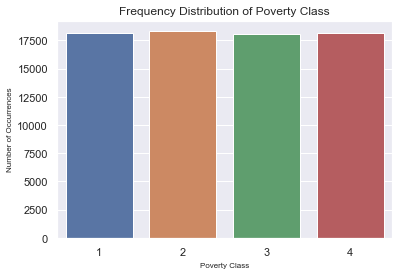

In [3]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
povertyClass_count = data2015['PovertyClass'].value_counts()
sns.set(style="darkgrid")
sns.barplot(povertyClass_count.index, povertyClass_count.values)
plt.title('Frequency Distribution of Poverty Class')
plt.ylabel('Number of Occurrences', fontsize=8)
plt.xlabel('Poverty Class', fontsize=8)
plt.show()

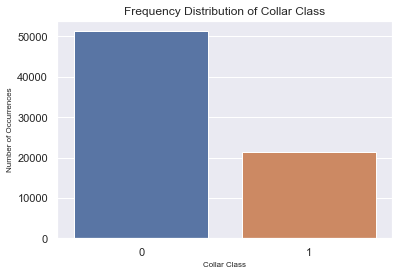

In [4]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
collarClass_count = data2015['CollarClass'].value_counts()
sns.set(style="darkgrid")
sns.barplot(collarClass_count.index, collarClass_count.values)
plt.title('Frequency Distribution of Collar Class')
plt.ylabel('Number of Occurrences', fontsize=8)
plt.xlabel('Collar Class', fontsize=8)
plt.show()

The last pre-processing step we took was to remove variables that are not needed/useful for analysis. 

We removed *Poverty* because it is the continuous version of our class variable, *Poverty Class*. We created percentage variables for *Citizen* and *Employed*, therefore we can remove the aggregate numerical versions. We also removed *TotalPop, Men,* and *Women* because they are also aggregate counts of the total population of that variable in the geographical line item. They were also deemed not useful for analysis by our EDA in Lab 1. We want all of our population counts to be percentages so they are on the same scale for each geographical area. This makes sure that the population size of the geographical area does not skew the model. 

There are four income variables in our data set: *Income, IncomeErr, IncomePerCap* and *IncomePerCapErr*. These are all highly correlated variables to each other and depict the same information in different ways. Therefore, since we do not want duplicate data we only want to use one for our model. Therefore, we took out *IncomeErr, IncomePerCap* and *IncomePerCapErr*, leaving just *Income* in our data set for model building. The *Income* variable depicts the median household income in USD for that geographical line item. 

We removed any geographically identifying variables from our data set so that our models would not train on location. This allows our model to be potentially run on any geographical area regardless of size and location to predict the *Poverty Class* in that area. The specific geographically identifying variables we removed are *CensusTract, County,* and *State*. 

In [5]:
#Remove variables that are not needed/useful for analysis.
#Remove aggregate numerical population count variables
del data2015['Poverty']
del data2015['TotalPop']
del data2015['Citizen']
del data2015['Men']
del data2015['Women']
del data2015['Employed']

#Remove income varaibles since we are using just Income
del data2015['IncomeErr']
del data2015['IncomePerCap']
del data2015['IncomePerCapErr']

#Remove geographically identifying varaibles
del data2015['State']
del data2015['County']
del data2015['CensusTract']

In addition, we removed the employment classification variables that make up our second task: *Collar Class*. These consist of the variables: *Professional, Office, Construction, Production, and Service*. These variables would considered repetitive data, now that we have the *Collar Class* variable.

In [6]:
census_pc = data2015.copy()
del census_pc['CollarClass']

census_cc = data2015.copy()
del census_cc['PovertyClass']
del census_cc['Professional']
del census_cc['Service']
del census_cc['Office']
del census_cc['Construction']
del census_cc['Production']

### **1.2 Data Preparation Part 2: Final Data Set For Classification/Regression**

Now we have two final data sets *census_pc* and *census_cc* that will be used for classification/regression of our two tasks *Poverty Class* and *Collar Class* respectively. Below is a description of our newly created variables:

    Newly created variables:
      PovertyClass - Depicts the poverty category (Low, Below Average, Above Average, High) of the geographical line item. [census_pc]
      CollarClass - Depicts the binary representation of white and blue collar job functions (White Collar, Blue Collar). [census_cc]
      CitizenPercent - Depicts the percentage (0 - 100%) of U.S. citizens in that geographical line item. [census_pc, census_cc]
      EmployedPercent - Depicts the percentage (0 - 100%) of employed persons in that geographical line item. [census_pc, census_cc]

We can also see the variable representations of our final data set. Every variable is a float except for our two task variables variables; *PovertyClass* and *Collar Class* which are category variables. 

Now that we have our final data sets, we can move on to [*Section 2: Modeling and Evaluation*](https://colab.research.google.com/drive/1fBFJCL0AUtZc_Zygo4NwYrBjoWFGUErf#scrollTo=5fVFEAYQRx0O).

In [7]:
census_pc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72671 entries, 0 to 74000
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Hispanic         72671 non-null  float64 
 1   White            72671 non-null  float64 
 2   Black            72671 non-null  float64 
 3   Native           72671 non-null  float64 
 4   Asian            72671 non-null  float64 
 5   Pacific          72671 non-null  float64 
 6   Income           72671 non-null  float64 
 7   CitizenPercent   72671 non-null  float64 
 8   ChildPoverty     72671 non-null  float64 
 9   Professional     72671 non-null  float64 
 10  Service          72671 non-null  float64 
 11  Office           72671 non-null  float64 
 12  Construction     72671 non-null  float64 
 13  Production       72671 non-null  float64 
 14  Drive            72671 non-null  float64 
 15  Carpool          72671 non-null  float64 
 16  Transit          72671 non-null  float64

In [8]:
census_cc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72671 entries, 0 to 74000
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Hispanic         72671 non-null  float64 
 1   White            72671 non-null  float64 
 2   Black            72671 non-null  float64 
 3   Native           72671 non-null  float64 
 4   Asian            72671 non-null  float64 
 5   Pacific          72671 non-null  float64 
 6   Income           72671 non-null  float64 
 7   CitizenPercent   72671 non-null  float64 
 8   ChildPoverty     72671 non-null  float64 
 9   Drive            72671 non-null  float64 
 10  Carpool          72671 non-null  float64 
 11  Transit          72671 non-null  float64 
 12  Walk             72671 non-null  float64 
 13  OtherTransp      72671 non-null  float64 
 14  WorkAtHome       72671 non-null  float64 
 15  MeanCommute      72671 non-null  float64 
 16  PrivateWork      72671 non-null  float64

##**2. Modeling and Evaluation**

### **2.1 Modeling and Evaluation 1: Evaluation Metrics**

For our *Poverty Class* task we will be leveraging accuracy as our primary evaluation metric. This is the most appropriate for analyzing the results of the *Poverty Class* task models because we have a balanced dataset when it comes to the classes of this variable. Also, we are trying to correctly classify geographical areas of extreme poverty in the United States and accuracy would be the most important outcome for this classification task. Focusing on achieving the highest accuracy would allow our model to be used in a multitude of ways such as the allocation of government social relief funds, private/public investment, school funding, etc. We will discuss the specific use cases of our models in [*Section 3: Deployment*](https://colab.research.google.com/drive/1fBFJCL0AUtZc_Zygo4NwYrBjoWFGUErf#scrollTo=z39eg-L9SD5l).

For our *Collar Class* task we will be leveraging multiple evaluation metrics since we are dealing with an imbalanced dataset. The classification of *white collar* will occur more frequently, therefore we would want to test high precision (low false positives). Since the *blue collar* outcome will occur less frequently we will need to test high recall (low false negatives). Overall we will want our task to be modeled with high accuracy, for the same reasons as listed above. 
  - High precision
  - High recall
  - High accuracy

### **2.2 Modeling and Evaluation 2: Training/Test Split Method**

We have chosen to use a 10 fold stratified model as our method for validation. The 10 fold stratified cross-validation procedure is a slight deviation from the k-fold cross validation procedure, in that it creates folds while maintaining the percentage of samples for each class. This allows us to have all the benefits of a 10 fold cross-validation without the model accuracy issues we would come across with an unbalanced dataset(e.g. *Collar Class* cross-validation). With a 10 fold stratified model we will be creating 9 folds to train our model and the 10th fold will be used as our test set. This process will be repeated and each of the folds will have the opportunity to be used as the test set. The complete 10 models are fit and evaluated while the performance of the model is calculated as the mean of the total runs.

In [10]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
import numpy as np

if 'PovertyClass' in census_pc:
    y_pc = census_pc['PovertyClass'].values # get the labels we want
    del census_pc['PovertyClass'] # get rid of the class label
    X_pc = census_pc.values # use everything else to predict! 
    
if 'CollarClass' in census_cc:
    y_cc = census_cc['CollarClass'].values # get the labels we want
    del census_cc['CollarClass'] # get rid of the class label
    X_cc = census_cc.values # use everything else to predict!  
    
num_cv_iterations = 10
num_instances = len(y_cc)
cv_object_GS = StratifiedKFold(n_splits=3,shuffle=True,random_state=13)
cv_object = StratifiedKFold(n_splits = num_cv_iterations, shuffle = True, random_state = 13)
print(cv_object_GS)
print(cv_object)

StratifiedKFold(n_splits=3, random_state=13, shuffle=True)
StratifiedKFold(n_splits=10, random_state=13, shuffle=True)


In [11]:
from sklearn.preprocessing import StandardScaler
# Scale the data
ss = StandardScaler()
X_pc = ss.fit_transform(X_pc)
X_cc = ss.fit_transform(X_cc)

### **2.3 Modeling and Evaluation 3: Creation of 3 Different Models**

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def FitAndPredictMulti(classifierEstimator, X, y, cv, modelType):
    from sklearn.model_selection import cross_val_predict
    from sklearn.metrics import confusion_matrix
    from sklearn import metrics as mt
    
    y_hat = cross_val_predict(classifierEstimator, X, y, cv=cv)
    acc = mt.accuracy_score(y,y_hat)
    
    print("Model Performance:")
    print("*******************************************************************************************************************")
    print("The accuracy of this",num_cv_iterations,"- fold, stratified cross validation",modelType,"model is:",round((acc*100),2),"%")
    print("")
    print("The confusion matrix for this",num_cv_iterations,"- fold, stratified cross validation",modelType,"model can be seen below.")
    print("")
    cm = confusion_matrix(y, y_hat)   
    plt.figure(figsize=(16,10))
    sns.heatmap(cm, annot=True, fmt='g',cmap = 'Blues',xticklabels=['Low','Below-Average','Above Average','High'], yticklabels=['Low','Below-Average','Above-Average','High']); 
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    print("Model Run Time: ")

roc_array = []
def FitAndPredictBinary(classifierEstimator, X, y, cv, modelType):
    from sklearn.model_selection import cross_val_predict
    from sklearn.metrics import roc_curve, roc_auc_score
    from sklearn.metrics import confusion_matrix
    from sklearn import metrics as mt
    
    y_hat = cross_val_predict(classifierEstimator, X, y, cv=cv)
    acc = mt.accuracy_score(y,y_hat)
    pre = mt.precision_score(y,y_hat)
    rec = mt.recall_score(y,y_hat)
    
    print("Model Performance:")
    print("*******************************************************************************************************************")
    print("The accuracy of this",num_cv_iterations,"- fold, stratified cross validation",modelType,"model is:",round((acc*100),2),"%")
    print("The precision of this",num_cv_iterations,"- fold, stratified cross validation",modelType,"model is:",round((pre*100),2),"%")
    print("The recall of this",num_cv_iterations,"- fold, stratified cross validation",modelType,"model is:",round((rec*100),2),"%")
    print("")
    print("The confusion matrix for this",num_cv_iterations,"- fold, stratified cross validation",modelType,"model can be seen below.")
    print("")
    cm = confusion_matrix(y, y_hat)
    plt.figure(figsize=(16,10))
    sns.heatmap(cm, annot=True, fmt='g',cmap = 'Blues',xticklabels=['White Collar','Blue Collar'], yticklabels=['White Collar','Blue Collar']); 
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    
    #print("ROC Curve Output:")
    #model = classifierEstimator.fit(X, y)
    #yproba = classifierEstimator.predict_proba(X)[::,1]
    #fpr, tpr, _ = roc_curve(y,  yproba)
    #auc = roc_auc_score(y, yproba)
    #roc_array = [fpr, tpr, auc, modelType]
    
    print("Model Run Time: ")

#### **2.3.1 Model 1 - KNN**

##### **2.3.1.1 KNN To Classify Poverty Class**

In [73]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
KNN_pcEstimator = KNeighborsClassifier()

KNN_pcparameters = { 'n_neighbors':[3, 9, 27, 261, 269, 275]
                  ,'weights': ['uniform', 'distance']
                  ,'algorithm': ['ball_tree', 'kd_tree', 'brute']
                  ,'leaf_size': [5, 10, 20, 40, 80]
                }

KNN_pcGridSearch = GridSearchCV(estimator=KNN_pcEstimator
                   , n_jobs=10 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=KNN_pcparameters
                   , cv=cv_object_GS # KFolds = 3
                   , scoring='accuracy')

KNN_pcGridSearch.fit(X_pc,y_pc)

Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed: 17.1min
/Users/reagan/opt/anaconda3/envs/MachineLearningI/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed: 98.1min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed: 550.5min
[Parallel(n_jobs=10)]: Done 540 out of 540 | elapsed: 572.4min finished


CPU times: user 10.4 s, sys: 3.4 s, total: 13.8 s
Wall time: 9h 32min 29s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=13, shuffle=True),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=10,
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [5, 10, 20, 40, 80],
                         'n_neighbors': [3, 9, 27, 261, 269, 275],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

In [74]:
KNN_pcGridSearch.best_estimator_

KNeighborsClassifier(algorithm='ball_tree', leaf_size=5, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=27, p=2,
                     weights='distance')

Model Performance:
*******************************************************************************************************************
The accuracy of this 10 - fold, stratified cross validation KNN model is: 71.35 %

The confusion matrix for this 10 - fold, stratified cross validation KNN model can be seen below.

Model Run Time: 
CPU times: user 6min 50s, sys: 1.66 s, total: 6min 51s
Wall time: 6min 51s


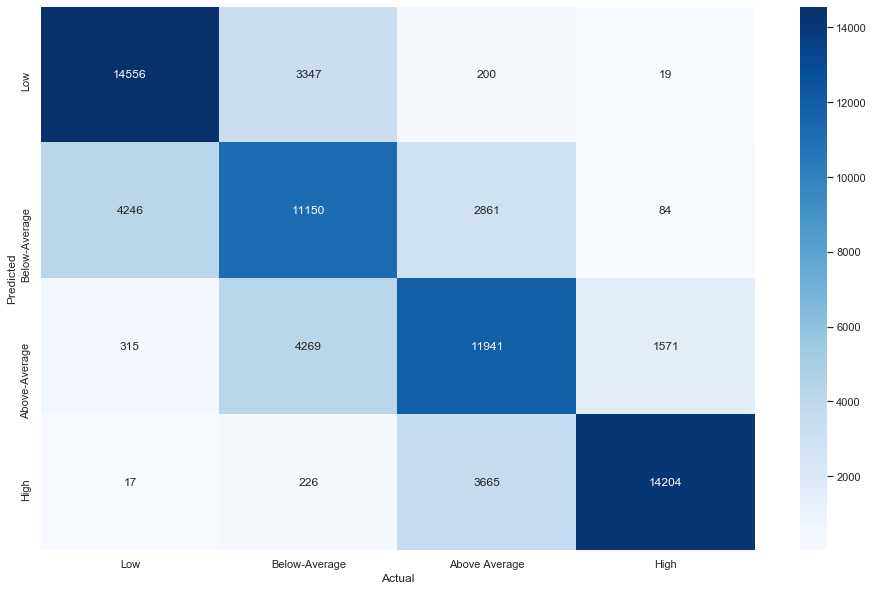

In [75]:
%%time
modelType = 'KNN'
KNN_pcBestParameters = KNN_pcGridSearch.best_estimator_
FitAndPredictMulti(KNN_pcBestParameters, X_pc, y_pc, cv_object, modelType)

##### **2.3.1.2 KNN To Classify Collar Class**

In [76]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
KNN_ccEstimator = KNeighborsClassifier()

KNN_ccparameters = { 'n_neighbors':[3, 9, 27, 261, 269, 275]
                  ,'weights': ['uniform', 'distance']
                  ,'algorithm': ['ball_tree', 'kd_tree', 'brute']
                  ,'leaf_size': [5, 10, 20, 40, 80]
                }

KNN_ccGridSearch = GridSearchCV(estimator=KNN_ccEstimator
                   , n_jobs=10 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=KNN_ccparameters
                   , cv=cv_object_GS # KFolds = 3
                   , scoring='accuracy')

KNN_ccGridSearch.fit(X_cc,y_cc)

Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed: 14.8min
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed: 83.5min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed: 170.7min
[Parallel(n_jobs=10)]: Done 540 out of 540 | elapsed: 195.4min finished


CPU times: user 9.61 s, sys: 3.84 s, total: 13.5 s
Wall time: 3h 15min 33s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=13, shuffle=True),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=10,
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [5, 10, 20, 40, 80],
                         'n_neighbors': [3, 9, 27, 261, 269, 275],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

In [77]:
KNN_ccGridSearch.best_estimator_

KNeighborsClassifier(algorithm='ball_tree', leaf_size=5, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=27, p=2,
                     weights='distance')

Model Performance:
*******************************************************************************************************************
The accuracy of this 10 - fold, stratified cross validation KNN model is: 82.66 %
The precision of this 10 - fold, stratified cross validation KNN model is: 74.29 %
The recall of this 10 - fold, stratified cross validation KNN model is: 62.77 %

The confusion matrix for this 10 - fold, stratified cross validation KNN model can be seen below.

Model Run Time: 
CPU times: user 5min 39s, sys: 1.53 s, total: 5min 40s
Wall time: 5min 40s


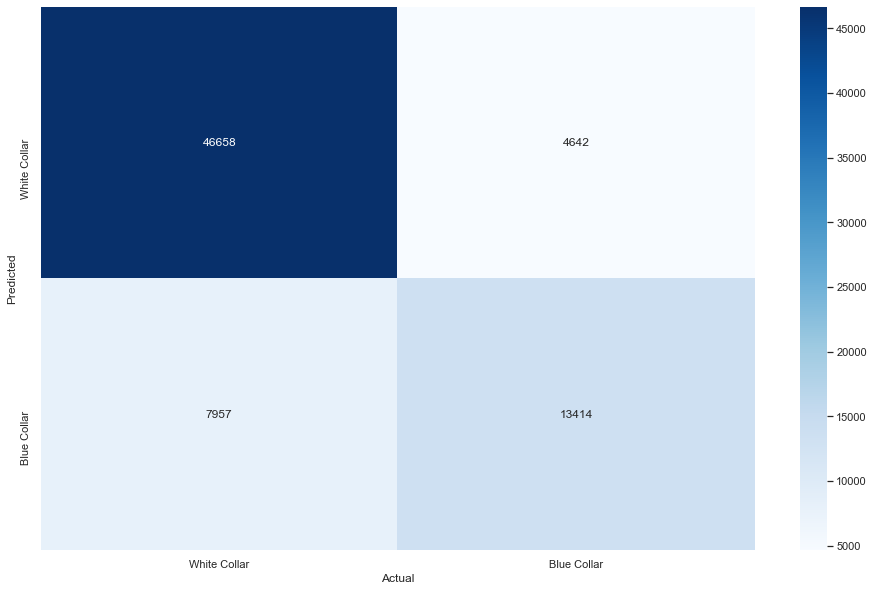

In [78]:
%%time
modelType = 'KNN'
KNN_ccBestParameters = KNN_ccGridSearch.best_estimator_
FitAndPredictBinary(KNN_ccBestParameters, X_cc, y_cc, cv_object, modelType)

#### **2.3.2 Model 2 - Random Forest**

##### **2.3.2.1 Random Forest To Classify Poverty Class**

In [19]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
RF_pcEstimator = RandomForestClassifier()

RF_pcparameters = { 'n_estimators':[50, 100, 200, 400]
                ,'max_depth': ['None', 25, 50, 100, 200]
                ,'criterion': ['gini', 'entropy']
                ,'min_samples_split': [2, 4, 16, 64, 256]
                ,'min_samples_leaf': [1, 4, 16, 64, 128]
                ,'random_state': [13]
               }

RF_pcGridSearch = GridSearchCV(estimator=RF_pcEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=RF_pcparameters
                   , cv=cv_object_GS # KFolds = 3
                   , scoring='accuracy')

RF_pcGridSearch.fit(X_pc,y_pc)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 342 tasks      | elapsed:  4.1min
[Parallel(n_jobs=8)]: Done 594 tasks      | elapsed: 20.3min
[Parallel(n_jobs=8)]: Done 944 tasks      | elapsed: 48.2min
[Parallel(n_jobs=8)]: Done 1394 tasks      | elapsed: 85.8min
[Parallel(n_jobs=8)]: Done 1944 tasks      | elapsed: 106.2min
[Parallel(n_jobs=8)]: Done 2594 tasks      | elapsed: 158.6min
[Parallel(n_jobs=8)]: Done 3000 out of 3000 | elapsed: 190.0min finished


CPU times: user 1min 43s, sys: 1.67 s, total: 1min 45s
Wall time: 3h 11min 36s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=13, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min...
                                              random_state=None, verbose=0,
                                              warm_start=False),
   

In [20]:
#Diplay the top model parameters
RF_pcGridSearch.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=13, verbose=0,
                       warm_start=False)

Model Performance:
*******************************************************************************************************************
The accuracy of this 10 - fold, stratified cross validation Random Forest model is: 81.0 %

The confusion matrix for this 10 - fold, stratified cross validation Random Forest model can be seen below.

Model Run Time: 
CPU times: user 13min 44s, sys: 4.55 s, total: 13min 49s
Wall time: 13min 50s


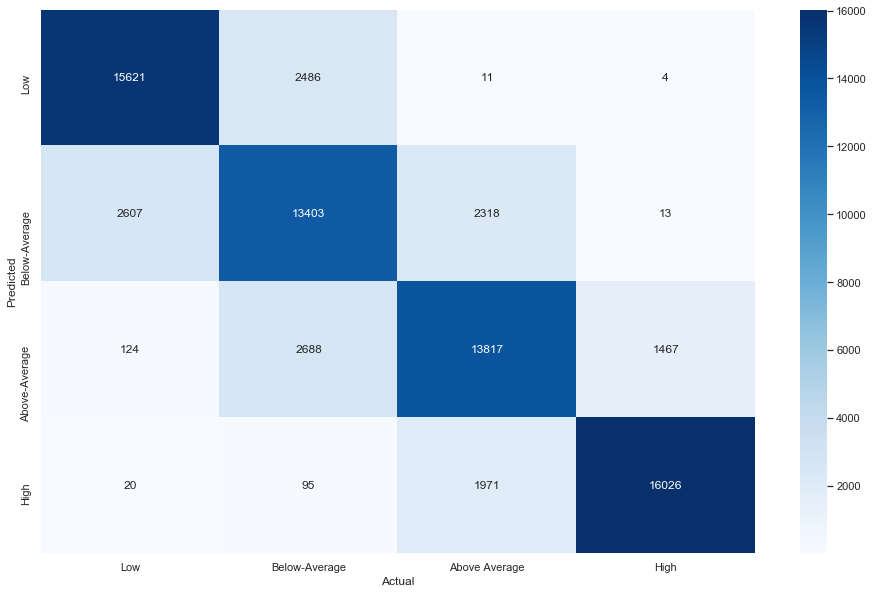

In [71]:
%%time
modelType = 'Random Forest'
RF_pcBestParameters = RF_pcGridSearch.best_estimator_
FitAndPredictMulti(RF_pcBestParameters, X_pc, y_pc, cv_object, modelType)

##### **2.3.2.2 Random Forest To Classify Collar Class**

In [22]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
RF_ccEstimator = RandomForestClassifier()

RF_ccparameters = { 'n_estimators':[50, 100, 200, 400]
                ,'max_depth': ['None', 25, 50, 100, 200]
                ,'criterion': ['gini', 'entropy']
                ,'min_samples_split': [2, 4, 16, 64, 256]
                ,'min_samples_leaf': [1, 4, 16, 64, 128]
                ,'random_state': [13]
               }

RF_ccGridSearch = GridSearchCV(estimator=RF_ccEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=RF_ccparameters
                   , cv=cv_object_GS # KFolds = 3
                   , scoring='accuracy')

RF_ccGridSearch.fit(X_cc,y_cc)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    6.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  9.1min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed: 29.4min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed: 54.9min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed: 70.1min
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed: 109.1min
[Parallel(n_jobs=8)]: Done 3000 out of 3000 | elapsed: 143.5min finished


CPU times: user 1min 18s, sys: 1.65 s, total: 1min 20s
Wall time: 2h 24min 40s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=13, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min...
                                              random_state=None, verbose=0,
                                              warm_start=False),
   

In [23]:
#Diplay the top model parameters
RF_ccGridSearch.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=13, verbose=0,
                       warm_start=False)

Model Performance:
*******************************************************************************************************************
The accuracy of this 10 - fold, stratified cross validation Random Forest model is: 83.79 %
The precision of this 10 - fold, stratified cross validation Random Forest model is: 75.88 %
The recall of this 10 - fold, stratified cross validation Random Forest model is: 65.79 %

The confusion matrix for this 10 - fold, stratified cross validation Random Forest model can be seen below.

Model Run Time: 
CPU times: user 9min 43s, sys: 3.15 s, total: 9min 46s
Wall time: 9min 46s


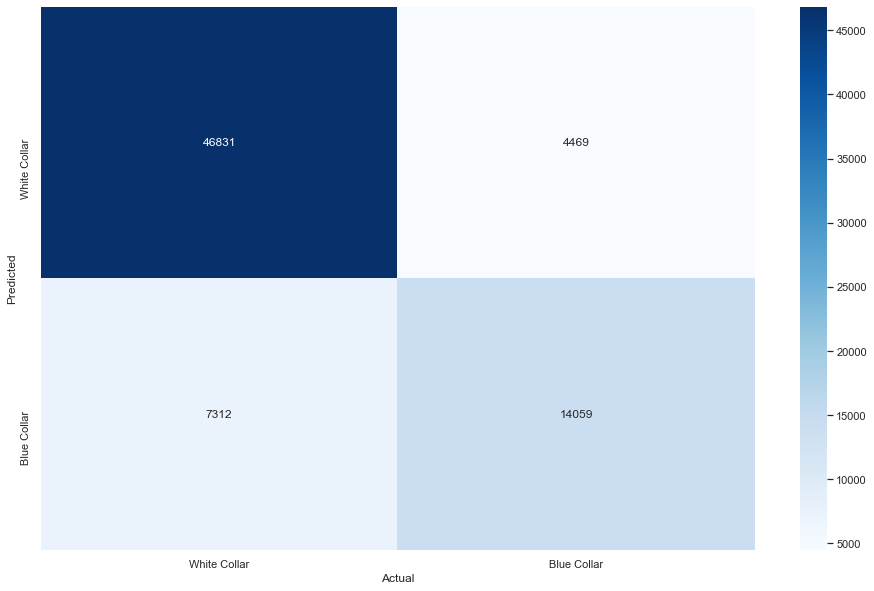

In [70]:
%%time
modelType = 'Random Forest'
RF_ccBestParameters = RF_ccGridSearch.best_estimator_
FitAndPredictBinary(RF_ccBestParameters, X_cc, y_cc, cv_object, modelType)

#### **2.3.3 Model 3 - Logistic Regression**

##### **2.3.3.1 Logistic Regression To Classify Poverty Class**

In [13]:
%%time
from sklearn.linear_model import LogisticRegression
LR_pcEstimator = LogisticRegression()

LR_pcparameters = { 'penalty':['l1','elasticnet','l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced','none']
              ,'solver': ['lbfgs','saga','newton-cg','liblinear']
              ,'multi_class': ['multinomial']
              ,'max_iter':[500, 2500, 5000, 10000]
              ,'random_state': [13]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
LR_pcGridSearch = GridSearchCV(estimator=LR_pcEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=LR_pcparameters
                   , cv=cv_object_GS # KFolds = 3
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
LR_pcGridSearch.fit(X_pc,y_pc)

Fitting 3 folds for each of 672 candidates, totalling 2016 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.0s
[Parallel(n_jobs=8)]: Done 189 tasks      | elapsed:   13.4s
[Parallel(n_jobs=8)]: Done 730 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 1288 tasks      | elapsed:  5.5min
[Parallel(n_jobs=8)]: Done 1816 tasks      | elapsed:  9.4min
[Parallel(n_jobs=8)]: Done 2016 out of 2016 | elapsed: 10.8min finished


CPU times: user 18.6 s, sys: 681 ms, total: 19.3 s
Wall time: 11min 2s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=13, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=8,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'class_weight': ['balanced', 'none'],
                         'max_iter': [500, 2500, 5000, 10000],
                         'multi_class': ['multinomial'],
                         'penalty'

In [14]:
#Diplay the top model parameters
LR_pcGridSearch.best_estimator_

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=500, multi_class='multinomial', n_jobs=None,
                   penalty='l1', random_state=13, solver='saga', tol=0.0001,
                   verbose=0, warm_start=False)

Model Performance:
*******************************************************************************************************************
The accuracy of this 10 - fold, stratified cross validation Logistic Regression model is: 79.5 %

The confusion matrix for this 10 - fold, stratified cross validation Logistic Regression model can be seen below.

Model Run Time: 
CPU times: user 2min 27s, sys: 2.85 s, total: 2min 30s
Wall time: 2min 26s


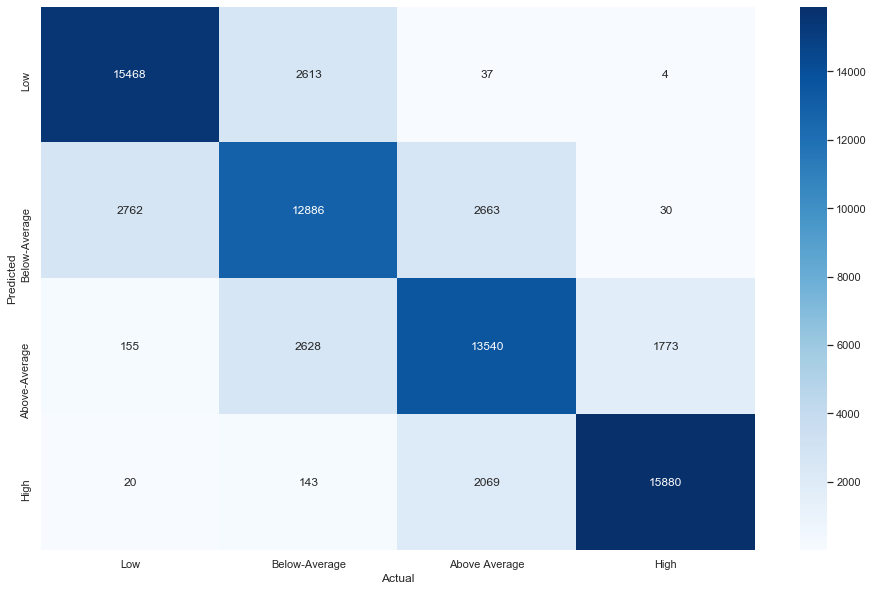

In [68]:
%%time
modelType = 'Logistic Regression'
LR_pcBestParameters = LR_pcGridSearch.best_estimator_
FitAndPredictMulti(LR_pcBestParameters, X_pc, y_pc, cv_object, modelType)

##### **2.3.3.2 Logistic Regression To Classify Collar Class**

In [16]:
%%time
from sklearn.linear_model import LogisticRegression
LR_ccEstimator = LogisticRegression()

LR_ccparameters = { 'penalty':['l1','elasticnet','l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced','none']
              ,'solver': ['lbfgs','saga','newton-cg','liblinear']
              ,'multi_class': ['ovr']
              ,'max_iter':[500, 2500, 5000, 10000]
              ,'random_state': [13]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
LR_ccGridSearch = GridSearchCV(estimator=LR_ccEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=LR_ccparameters
                   , cv=cv_object_GS # KFolds = 3
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
LR_ccGridSearch.fit(X_cc,y_cc)

Fitting 3 folds for each of 672 candidates, totalling 2016 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:   14.6s
[Parallel(n_jobs=8)]: Done 602 tasks      | elapsed:   35.1s
[Parallel(n_jobs=8)]: Done 952 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done 1402 tasks      | elapsed:  6.3min
[Parallel(n_jobs=8)]: Done 1952 tasks      | elapsed: 10.8min


CPU times: user 6.62 s, sys: 755 ms, total: 7.38 s
Wall time: 11min 30s


[Parallel(n_jobs=8)]: Done 2016 out of 2016 | elapsed: 11.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=13, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=8,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'class_weight': ['balanced', 'none'],
                         'max_iter': [500, 2500, 5000, 10000],
                         'multi_class': ['ovr'],
                         'penalty': ['l1',

In [17]:
#Diplay the top model parameters
LR_ccGridSearch.best_estimator_

LogisticRegression(C=0.1, class_weight='none', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=13, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Model Performance:
*******************************************************************************************************************
The accuracy of this 10 - fold, stratified cross validation Logistic Regression model is: 82.01 %
The precision of this 10 - fold, stratified cross validation Logistic Regression model is: 73.18 %
The recall of this 10 - fold, stratified cross validation Logistic Regression model is: 61.26 %

The confusion matrix for this 10 - fold, stratified cross validation Logistic Regression model can be seen below.

Model Run Time: 
CPU times: user 4.68 s, sys: 575 ms, total: 5.26 s
Wall time: 1.35 s


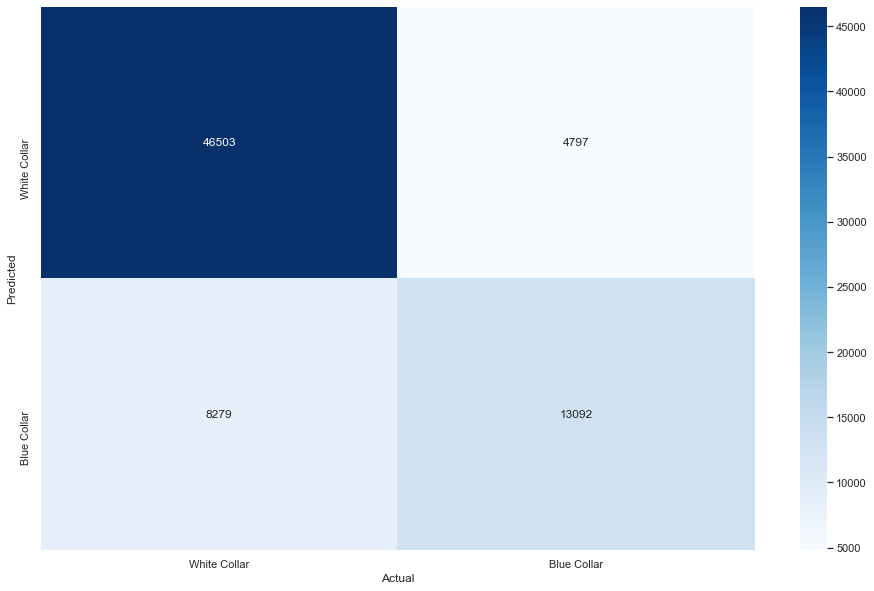

In [69]:
%%time
modelType = 'Logistic Regression'
LR_ccBestParameters = LR_ccGridSearch.best_estimator_
FitAndPredictBinary(LR_ccBestParameters, X_cc, y_cc, cv_object, modelType)

### **2.4 Modeling and Evaluation 4: Analyze Results**

|  Class Variable  |  Model                 |  Accuracy  |    Time    |
|------------------|------------------------|------------|------------|
| PovertyClass     |  KNN                   |            |            |
| PovertyClass     |  Random Forest         |            |            |
| PovertyClass     |  Logistic Regression   

|Class Variable|Model|Precision|Recall|Accuracy|Time|
|------------------|------------------------|-------|-------|----|----|
| CollarClass      |  KNN                   |       |       |    |    |
| CollarClass      |  Random Forest         |       |       |    |    |
| CollarClass      |  Logistic Regression   |       |       |    |    |

### **2.5 Modeling and Evaluation 5: Advantages of Each Model**

### **2.6 Modeling and Evaluation 6: Identify Important Attributes**

##**3. Deployment**

##**4. Exceptional Work**

Decision Tree